# Import Libraries

In [1]:
!pip install -r requirements.txt

In [2]:
!pip install numpy==2.0.1

In [5]:
# Datahandling
import os
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.sparse
import matplotlib.pyplot as plt

# Maskinlæring
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report)
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, mutual_info_classif
import xgboost as xgb

# Transformer-modeller
from transformers import (BertTokenizer, BertModel, 
                          DistilBertTokenizer, DistilBertModel)

# Andre biblioteker
import torch
import gradio as gr
import joblib


# Data

In [7]:
# Data import 
data = pd.read_csv('TwitterData_Joined.csv')

In [8]:
# Display the first few rows of the dataset
data.head(15)

Twitter_User_Name Twitter_Account  \
0         Museum Bot       MuseumBot   
1         Museum Bot       MuseumBot   
2         Museum Bot       MuseumBot   
3         Museum Bot       MuseumBot   
4         Museum Bot       MuseumBot   
5         Museum Bot       MuseumBot   
6         Museum Bot       MuseumBot   
7         Museum Bot       MuseumBot   
8         Museum Bot       MuseumBot   
9         Museum Bot       MuseumBot   
10        Museum Bot       MuseumBot   
11        Museum Bot       MuseumBot   
12        Museum Bot       MuseumBot   
13        Museum Bot       MuseumBot   
14        Museum Bot       MuseumBot   

                             Twitter_User_Description      Tweet_id  \
0   I am a bot that tweets a random high-res Open ...  8.027580e+17   
1   I am a bot that tweets a random high-res Open ...  8.746920e+17   
2   I am a bot that tweets a random high-res Open ...  6.983900e+17   
3   I am a bot that tweets a random high-res Open ...  6.976650e+17   
4   I am a bot that tweets a random high-res Open ...  6.217450e+17   
5   I am a bot that tweets a random high-res Open ...  8.783910e+17   
6   I am a bot that tweets a random high-res Open ...  8.852010e+17   
7   I am a bot that tweets a random high-res Open ...  6.618790e+17   
8   I am a bot that tweets a random high-res Open ...  5.573150e+17   
9   I am a bot that tweets a random high-res Open ...  5.355720e+17   
10  I am a bot that tweets a random high-res Open ...  7.650690e+17   
11  I am a bot that tweets a random high-res Open ...  7.715920e+17   
12  I am a bot that tweets a random high-res Open ...  6.429450e+17   
13  I am a bot that tweets a random high-res Open ...  6.450130e+17   
14  I am a bot that tweets a random high-res Open ...  6.740040e+17   

    Tweet_created_at                                         Tweet_text  \
0   27-11-2016 06:15  Imperial Theatrical Coat for Court Lady https:...   
1   13-06-2017 18:15  Half-length Figure of St Paul in an Oval. http...   
2   13-02-2016 06:15  Great Exhibition Jurors&amp;#39; Medal https:/...   
3   11-02-2016 06:15  Pair of candelabra https://t.co/KYopSWDSw2 htt...   
4   16-07-2015 18:15  Banner (Nobori)\n http://t.co/yz34Xgo9a5 http:...   
5   23-06-2017 23:15  A Small Piece of Turf https://t.co/Yucl869j6X ...   
6   12-07-2017 18:15  Finger ring https://t.co/qAJhdi4VCG https://t....   
7   04-11-2015 12:15  Ornaments https://t.co/WnUMY17C9w https://t.co...   
8   19-01-2015 23:15  Lady Maria Conyngham (died 1843) http://t.co/I...   
9   20-11-2014 23:15  Frame http://t.co/9hsuSqDCah http://t.co/JYWtW...   
10  15-08-2016 06:15  Piece https://t.co/fS64spFNgf https://t.co/9MJ...   
11  02-09-2016 06:15  [House with Palm Tree] https://t.co/8FLyTU3Tcc...   
12  13-09-2015 06:15  Oval dish http://t.co/H8sWZuTkZI http://t.co/B...   
13  18-09-2015 23:15  Serving spoon http://t.co/VI8zaSXorf http://t....   
14  07-12-2015 23:15  Penitent Saint Jerome https://t.co/4gPTzAtHUZ ...   

    Label  Word_Count  Url_Count  Retweet  ... Adverb_Count  \
0       0           8          2        0  ...            0   
1       0          10          2        0  ...            0   
2       0           6          2        0  ...            0   
3       0           5          2        0  ...            0   
4       0           4          2        0  ...            0   
5       0           7          2        0  ...            0   
6       0           4          2        0  ...            0   
7       0           3          2        0  ...            0   
8       0           7          2        0  ...            0   
9       0           3          2        0  ...            0   
10      0           3          2        0  ...            0   
11      0           6          2        0  ...            0   
12      0           4          2        0  ...            0   
13      0           4          2        0  ...            0   
14      0           5          2        0  ...            0   

    Positive_Wo

In [9]:
import pandas as pd
import re

# Antager at du allerede har importeret datasættet som 'data'
# Hvis datasættet er importeret som 'data', kan du fortsætte direkte fra her

# Funktion til at finde URL'er i tekst
# Opdateret regex for at finde mere generelle URL'er
def find_urls(text):
    # Regular expression til at finde URL'er, som kan inkludere både http(s) og uden http
    url_pattern = r'(\b(?:https?://|www\.)[a-zA-Z0-9-_.]+\.[a-zA-Z]{2,}\b(?:[^\s]*))'
    return re.findall(url_pattern, text)

# Find alle URL'er i Tweet-kolonnen
urls = data['Tweet_text'].apply(find_urls)

# Saml alle URL'er i en liste
all_urls = [url for sublist in urls for url in sublist]

# Fjern duplikater
unique_urls = list(set(all_urls))

# Udskriv listen med unikke URL'er
print(unique_urls)



['https://t.co/4swxHRr7og', 'https://t.co/Rgoa3bsZOQ', 'https://t.co/n3kOcB4dUR', 'https://t.co/Oykoi8ktUR', 'https://t.co/SXBh1klPnV', 'https://t.co/SO7xFaULRi', 'https://t.co/khcAml5fcI', 'https://t.co/CtlKcVzTSn', 'https://t.co/JH0hFQFRs3', 'https://t.co/rMBHlIiyU7', 'https://t.co/ZB9Usvmi7s', 'http://t.co/S0wVSlBlmj', 'https://t.co/4lv4U2Gkmc', 'https://t.co/nXTzHEkYEv', 'https://t.co/cfQC6OSKMn', 'https://t.co/c9jUgJ1VMY', 'https://t.co/OYg7eGbgLr', 'https://t.co/mzq9fTRwuq', 'https://t.co/XskiRcrBZi', 'https://t.co/R2s5kirPIp', 'https://t.co/yUh1L5lXsa', 'https://t.co/2m3gP1p62f', 'https://t.co/b1aoZFShWy', 'https://t.co/od0WoGBwNA', 'https://t.co/V3tPmKmyUo', 'https://t.co/BaTXhbe6jY', 'https://t.co/UDHOEElDgU', 'https://t.co/koFz7jKbkB', 'http://t.co/BerygI9RMC', 'https://t.co/u9rIuyvxJT', 'https://t.co/aARZNFOe5R', 'https://t.co/Ok1KdPoALe', 'http://t.co/t43h0YtMP5', 'https://t.co/S2IJjHdRjn', 'https://t.co/69X9fJWXJf', 'https://t.co/1gy1DlSgmS', 'https://t.co/g2Ox4afMAb', 'ht

In [10]:
data.Label.value_counts()

Label
1    144224
0    135467
Name: count, dtype: int64

In [11]:
# Display basic information about the dataset
print("\nBasic information about the dataset:")
print(data.info())


Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279691 entries, 0 to 279690
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Twitter_User_Name         279691 non-null  object 
 1   Twitter_Account           279691 non-null  object 
 2   Twitter_User_Description  276027 non-null  object 
 3   Tweet_id                  279691 non-null  float64
 4   Tweet_created_at          279691 non-null  object 
 5   Tweet_text                279691 non-null  object 
 6   Label                     279691 non-null  int64  
 7   Word_Count                279691 non-null  int64  
 8   Url_Count                 279691 non-null  int64  
 9   Retweet                   279691 non-null  int64  
 10  Original_User             58391 non-null   object 
 11  Mentions_Count            279691 non-null  int64  
 12  Hashtags_Count            279691 non-null  int64  
 13  QuesMa

## DATA IMPORT AND SAMPLING (to be sorted....)

In [12]:
# DATA IMPORT & SAMPLING
data = pd.read_csv('TwitterData_Joined.csv')
data = data.sample(n=500, random_state=19)

In [13]:
# -------------------------------------------------
# Dropping Constant features and non-numeric values
# -------------------------------------------------
data = data.copy()
data = data.select_dtypes(include=['int64', 'float64'])
constant_columns = data.columns[data.nunique() == 1]
sml_data = data.drop(columns=constant_columns)
sml_data

Tweet_id  Label  Word_Count  Url_Count  Retweet  Mentions_Count  \
20383   7.180750e+17      0           7          0        0               0   
102418  1.071630e+18      1          23          0        1               2   
277786  8.453450e+17      1          21          0        1               0   
242954  5.406010e+17      0          12          1        0               0   
187582  7.496720e+17      1          20          0        0               3   
...              ...    ...         ...        ...      ...             ...   
15421   1.070920e+18      0          15          0        0               0   
9432    8.693420e+17      0           2          0        0               1   
100670  8.623520e+17      0           1          1        0               0   
7883    1.033440e+18      0          18          1        1               0   
21055   6.702270e+17      0           7          0        0               0   

        Hashtags_Count  QuesMark_Count  Exclamations_Count  \
20383                0               0                   0   
102418               1               0                   0   
277786               1               0                   0   
242954               0               0                   0   
187582               0               0                   0   
...                ...             ...                 ...   
15421                0               1                   0   
9432                 0               0                   0   
100670               0               0                   0   
7883                 0               0                   0   
21055                0               0                   0   

        SpecialCharacters_Count  ...  Pronouns_Count  Verb_Count  \
20383                         1  ...               0           1   
102418                       10  ...               0           3   
277786                        9  ...               0           1   
242954                        1  ...               0           0   
187582                        3  ...               0           2   
...                         ...  ...             ...         ...   
15421                        24  ...               0           0   
9432                          2  ...               0           0   
100670                        0  ...               0           0   
7883                          5  ...               0           2   
21055                         1  ...               0           1   

        Adverb_Count  Positive_Word_Ratio  Negative_Word_Ratio  \
20383              0             0.125000             0.000000   
102418             1             0.066667             0.033333   
277786             0             0.066667             0.000000   
242954             0             0.071429             0.000000   
187582             1             0.086957             0.000000   
...              ...                  ...                  ...   
15421              1             0.058824             0.058824   
9432               0             0.000000             0.000000   
100670             0             0.000000             0.000000   
7883               0             0.080000             0.040000   
21055              1             0.125000             0.000000   

        Neutral_Word_Ratio  Following  Followers  Verified  Real_Location  
20383             0.875000         75        241         0           -1.0  
102418            0.900000      55000      75700         0            1.0  
277786            0.933333        445        875         0            1.0  
242954            0.928571          4        608         0           -1.0  
187582            0.913043       1440       2420         0           -1.0  
...                    ...        ...        ...       ...            ...  
15421             0.882353          5       4700         0            0.0  
9432              1.000000       2666        892         0            1.0  
100670            1.0000

In [14]:
# Moving the Label Column to the last and then rearranging the data randomly
# --------------------------------------------------------------------------
# Also dropping suspended accounts
label_column = sml_data['Label']
sml_data = sml_data.drop(columns=['Label'])
sml_data['Label'] = label_column
sml_data = sml_data.sample(frac=1, random_state=42).reset_index(drop=True)
sml_data = sml_data[sml_data['Verified'] != -1]
sml_data

Tweet_id  Word_Count  Url_Count  Retweet  Mentions_Count  \
0    9.699320e+17          11          0        0               1   
1    6.659460e+17          13          0        0               0   
2    7.227200e+17          12          1        1               0   
3    9.928610e+17           2          1        0               1   
4    5.524280e+17          21          1        1               0   
..            ...         ...        ...      ...             ...   
495  7.249210e+17          11          1        0               2   
496  7.162730e+17           8          0        0               1   
497  1.060250e+18           5          0        0               1   
498  7.220550e+17          11          2        1               2   
499  7.169890e+17          16          0        1               0   

     Hashtags_Count  QuesMark_Count  Exclamations_Count  \
0                 0               0                   0   
1                 0               1                   0   
2                 1               0                   0   
3                 0               0                   0   
4                 0               0                   0   
..              ...             ...                 ...   
495               0               0                   0   
496               0               0                   0   
497               0               1                   0   
498               1               0                   0   
499               3               0                   1   

     SpecialCharacters_Count  Nouns_Count  ...  Verb_Count  Adverb_Count  \
0                          1            4  ...           3             1   
1                          1            4  ...           1             0   
2                          6           10  ...           1             0   
3                          1            3  ...           0             0   
4                          6           15  ...           1             0   
..                       ...          ...  ...         ...           ...   
495                        2           10  ...           2             0   
496                        1            2  ...           1             0   
497                        2            4  ...           1             0   
498                        9           14  ...           0             0   
499                       13           11  ...           1             0   

     Positive_Word_Ratio  Negative_Word_Ratio  Neutral_Word_Ratio  Following  \
0               0.083333             0.000000            0.916667         13   
1               0.000000             0.000000            1.000000       1440   
2               0.000000             0.150000            0.850000          2   
3               0.000000             0.000000            1.000000          2   
4               0.071429             0.035714            0.892857       1817   
..                   ...                  ...                 ...        ...   
495             0.000000             0.000000            1.000000       1974   
496             0.222222             0.000000            0.777778      20500   
497             0.000000             0.000000            1.000000        941   
498             0.000000             0.000000            1.000000          2   
499             0.000000             0.071429            0.928571          2   

     Followers  Verified  Real_Location  Label  
0      9400000         1            1.0      1  
1         2420         0           -1.0      1  
2          594         0            0.0      0  
3         2828         0            0.0      0  
4          963         0            1.0      1  
..         ...       ...            ...    ...  
495       5674         0           -1.0      1  
496      30100         0            1.0      1  
497      21200         0            0.0      1  
498        594         0            0.0      0  
499        594         0            0.0      0  

[476 row

In [15]:
# Checking for Constant columns using VarianceThreshold
var_thres = VarianceThreshold(threshold=0)
var_thres.fit(sml_data)
# Get columns with variance
non_constant_columns = sml_data.columns[var_thres.get_support()]
# Drop constant columns
sml_data = sml_data[non_constant_columns]
sml_data

Tweet_id  Word_Count  Url_Count  Retweet  Mentions_Count  \
0    9.699320e+17          11          0        0               1   
1    6.659460e+17          13          0        0               0   
2    7.227200e+17          12          1        1               0   
3    9.928610e+17           2          1        0               1   
4    5.524280e+17          21          1        1               0   
..            ...         ...        ...      ...             ...   
495  7.249210e+17          11          1        0               2   
496  7.162730e+17           8          0        0               1   
497  1.060250e+18           5          0        0               1   
498  7.220550e+17          11          2        1               2   
499  7.169890e+17          16          0        1               0   

     Hashtags_Count  QuesMark_Count  Exclamations_Count  \
0                 0               0                   0   
1                 0               1                   0   
2                 1               0                   0   
3                 0               0                   0   
4                 0               0                   0   
..              ...             ...                 ...   
495               0               0                   0   
496               0               0                   0   
497               0               1                   0   
498               1               0                   0   
499               3               0                   1   

     SpecialCharacters_Count  Nouns_Count  ...  Verb_Count  Adverb_Count  \
0                          1            4  ...           3             1   
1                          1            4  ...           1             0   
2                          6           10  ...           1             0   
3                          1            3  ...           0             0   
4                          6           15  ...           1             0   
..                       ...          ...  ...         ...           ...   
495                        2           10  ...           2             0   
496                        1            2  ...           1             0   
497                        2            4  ...           1             0   
498                        9           14  ...           0             0   
499                       13           11  ...           1             0   

     Positive_Word_Ratio  Negative_Word_Ratio  Neutral_Word_Ratio  Following  \
0               0.083333             0.000000            0.916667         13   
1               0.000000             0.000000            1.000000       1440   
2               0.000000             0.150000            0.850000          2   
3               0.000000             0.000000            1.000000          2   
4               0.071429             0.035714            0.892857       1817   
..                   ...                  ...                 ...        ...   
495             0.000000             0.000000            1.000000       1974   
496             0.222222             0.000000            0.777778      20500   
497             0.000000             0.000000            1.000000        941   
498             0.000000             0.000000            1.000000          2   
499             0.000000             0.071429            0.928571          2   

     Followers  Verified  Real_Location  Label  
0      9400000         1            1.0      1  
1         2420         0           -1.0      1  
2          594         0            0.0      0  
3         2828         0            0.0      0  
4          963         0            1.0      1  
..         ...       ...            ...    ...  
495       5674         0           -1.0      1  
496      30100         0            1.0      1  
497      21200         0            0.0      1  
498        594         0            0.0      0  
499        594         0            0.0      0  

[476 row

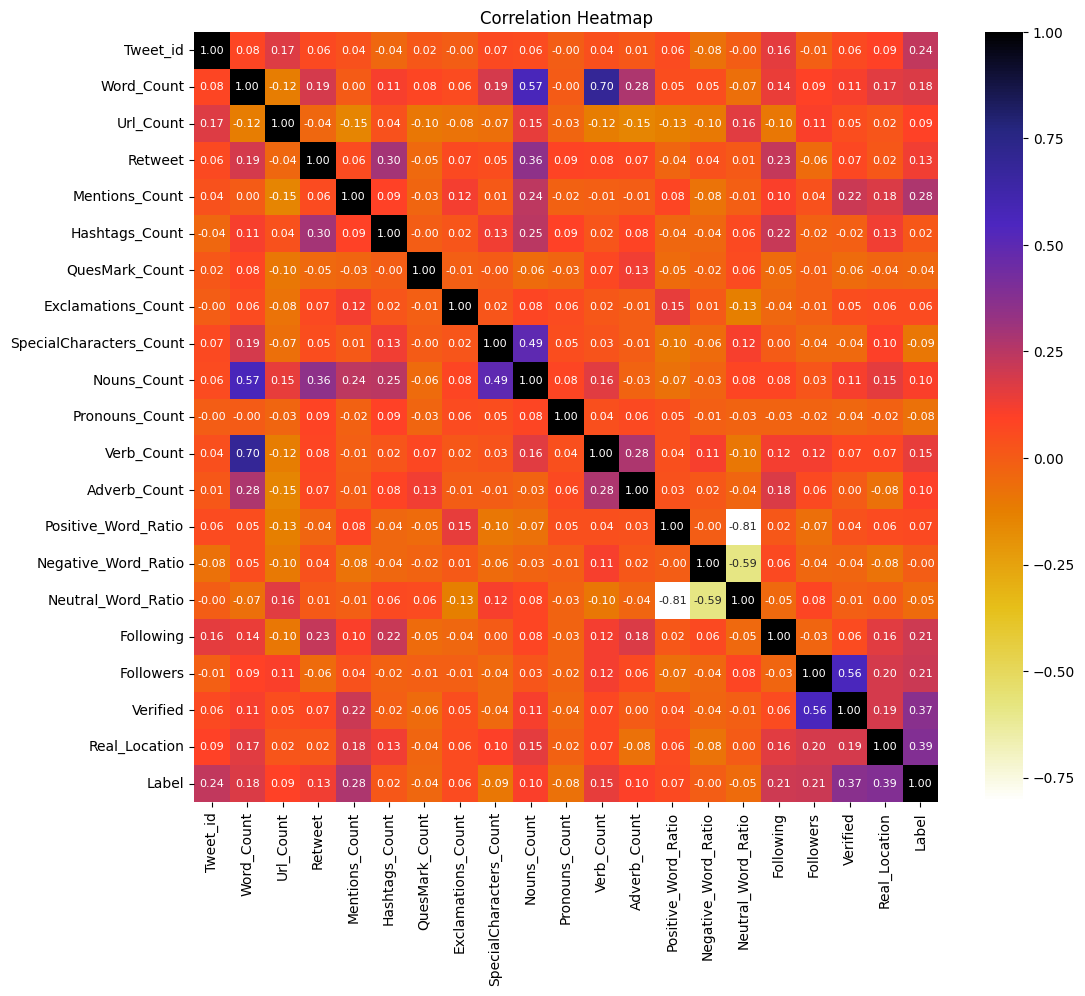

In [16]:
plt.figure(figsize=(12,10))
cor = sml_data.corr()
sns.heatmap(cor, cmap=plt.cm.CMRmap_r, 
            annot=True, 
            fmt='.2f',  # Limit to 2 decimal places
            annot_kws={'size':8},  # Smaller font
            cbar=True)
plt.title('Correlation Heatmap')
plt.show()

In [17]:
sml_data = sml_data.drop(columns=['Tweet_id'])
sml_data

Word_Count  Url_Count  Retweet  Mentions_Count  Hashtags_Count  \
0            11          0        0               1               0   
1            13          0        0               0               0   
2            12          1        1               0               1   
3             2          1        0               1               0   
4            21          1        1               0               0   
..          ...        ...      ...             ...             ...   
495          11          1        0               2               0   
496           8          0        0               1               0   
497           5          0        0               1               0   
498          11          2        1               2               1   
499          16          0        1               0               3   

     QuesMark_Count  Exclamations_Count  SpecialCharacters_Count  Nouns_Count  \
0                 0                   0                        1            4   
1                 1                   0                        1            4   
2                 0                   0                        6           10   
3                 0                   0                        1            3   
4                 0                   0                        6           15   
..              ...                 ...                      ...          ...   
495               0                   0                        2           10   
496               0                   0                        1            2   
497               1                   0                        2            4   
498               0                   0                        9           14   
499               0                   1                       13           11   

     Pronouns_Count  Verb_Count  Adverb_Count  Positive_Word_Ratio  \
0                 0           3             1             0.083333   
1                 0           1             0             0.000000   
2                 0           1             0             0.000000   
3                 0           0             0             0.000000   
4                 0           1             0             0.071429   
..              ...         ...           ...                  ...   
495               0           2             0             0.000000   
496               0           1             0             0.222222   
497               0           1             0             0.000000   
498               0           0             0             0.000000   
499               0           1             0             0.000000   

     Negative_Word_Ratio  Neutral_Word_Ratio  Following  Followers  Verified  \
0               0.000000            0.916667         13    9400000         1   
1               0.000000            1.000000       1440       2420         0   
2               0.150000            0.850000          2        594         0   
3               0.000000            1.000000          2       2828         0   
4               0.035714            0.892857       1817        963         0   
..                   ...                 ...        ...        ...       ...   
495             0.000000            1.000000       1974       5674         0   
496             0.000000            0.777778      20500      30100         0   
497             0.000000            1.000000        941      21200         0   
498             0.000000            1.000000          2        594         0   
499             0.071429            0.928571          2        594         0   

     Real_Location  Label  
0              1.0      1  
1             -1.0      1  
2              0.0      0  
3              0.0      0  
4              1.0      1  
..             ...    ...  
495           -1.0      1  
496            1.0      1  
497            0.0      1  
498            0.0      0  
499            0.0      0  

[476 rows x 20 columns]

Correlated Features: {'Neutral_Word_Ratio'}
Original DataFrame shape: (476, 20)
Reduced DataFrame shape: (476, 19)


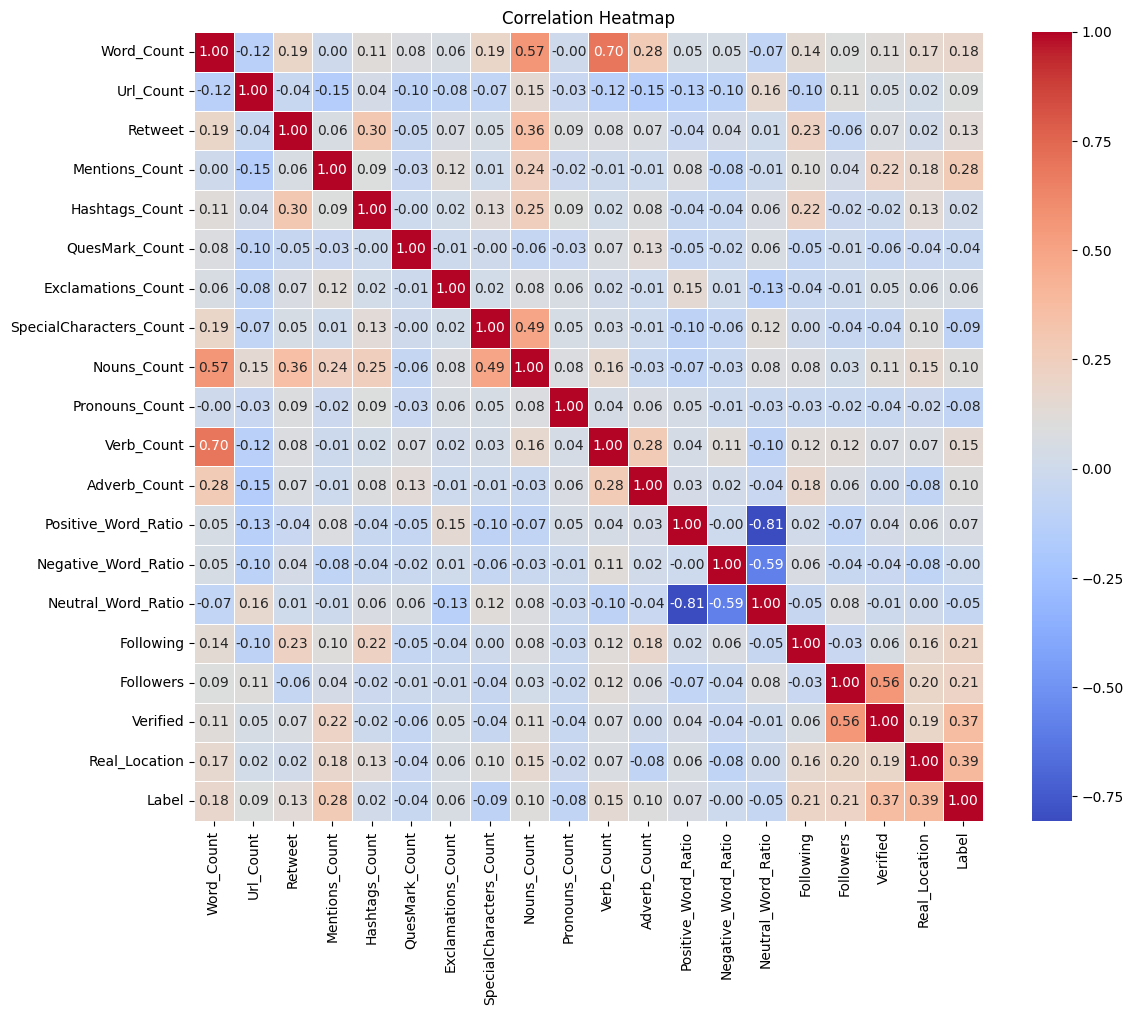

In [18]:
def identify_multicollinearity(df, threshold=0.75):
    # Ensure we're only looking at numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Create correlation matrix for numeric columns
    corr_matrix = df[numeric_cols].corr()
    
    # Set to store correlated features
    correlated_features = set()
    
    # Iterate through correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # Check if absolute correlation exceeds threshold
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                correlated_features.add(colname)
    
    return correlated_features
# Identify multicollinear features
multi_col_features = identify_multicollinearity(sml_data)
# Print correlated features
print("Correlated Features:", multi_col_features)
# Optional: Drop correlated features
sml_data_reduced = sml_data.drop(columns=list(multi_col_features))
# Optional: Print shape before and after
print("Original DataFrame shape:", sml_data.shape)
print("Reduced DataFrame shape:", sml_data_reduced.shape)
# Optional: Visualize correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(sml_data[sml_data.select_dtypes(include=['float64', 'int64']).columns].corr(), 
            annot=True, 
            cmap='coolwarm', 
            linewidths=0.5,
            fmt=".2f",
            square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

Followers                  0.528963
Following                  0.485734
Verified                   0.097456
Real_Location              0.090412
Word_Count                 0.055372
SpecialCharacters_Count    0.045387
Mentions_Count             0.025655
Hashtags_Count             0.025546
Retweet                    0.024002
Neutral_Word_Ratio         0.020766
Exclamations_Count         0.020644
Positive_Word_Ratio        0.011132
QuesMark_Count             0.001563
Nouns_Count                0.000000
Url_Count                  0.000000
Verb_Count                 0.000000
Adverb_Count               0.000000
Negative_Word_Ratio        0.000000
Pronouns_Count             0.000000
dtype: float64


/var/folders/xc/v1l81vkx6fjc9wpqc0tsnl400000gn/T/ipykernel_1715/4053215159.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sml_data['Real_Location'].fillna(-1, inplace=True)  # Use -1 for unknown locations


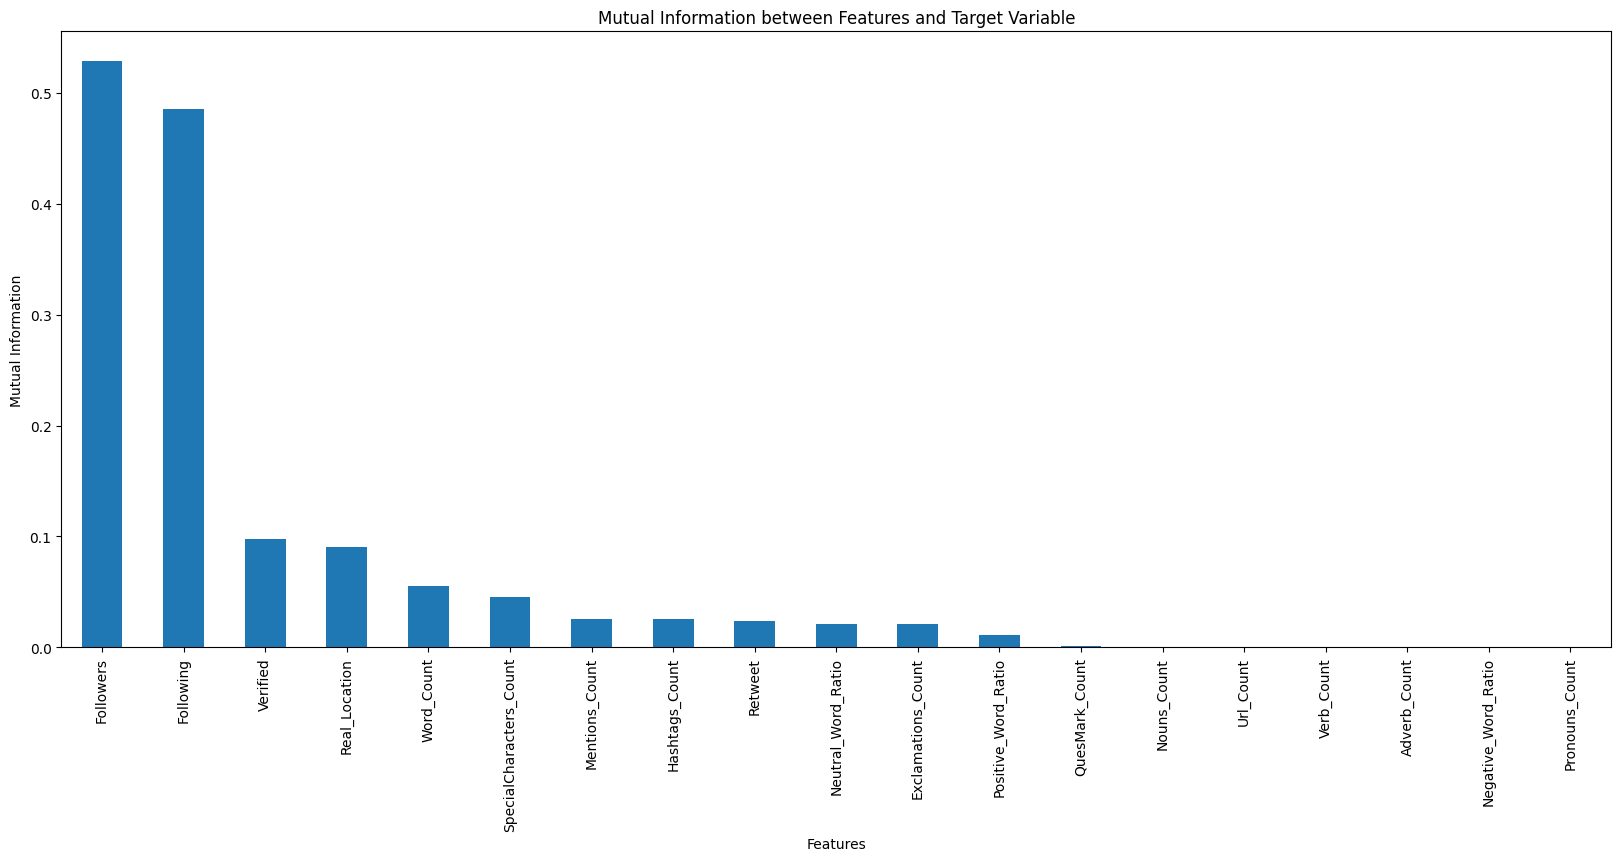

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt


# Assuming sml_data is your DataFrame
# Fill missing values in 'Real_Location'
sml_data['Real_Location'].fillna(-1, inplace=True)  # Use -1 for unknown locations


# Dropping non-numeric values and constant features
TheRealData = sml_data.select_dtypes(include=['int64', 'float64'])
constant_columns = TheRealData.columns[TheRealData.nunique() == 1]
TheRealData = TheRealData.drop(columns=constant_columns)


# Prepare features and target variable
X = TheRealData.drop(columns=['Label'])  # Adjust if 'Label' is not in TheRealData
y = sml_data['Label']  # Assuming 'Label' is in the original sml_data


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


# Calculate mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns


# Print and plot mutual information
print(mutual_info.sort_values(ascending=False))
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.title('Mutual Information between Features and Target Variable')
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.show()

Top 5 Features:
Index(['Word_Count', 'Following', 'Followers', 'Verified', 'Real_Location'], dtype='object')

Feature Scores:
Followers        0.555161
Following        0.491968
Verified         0.137680
Real_Location    0.123655
Word_Count       0.060377
dtype: float64


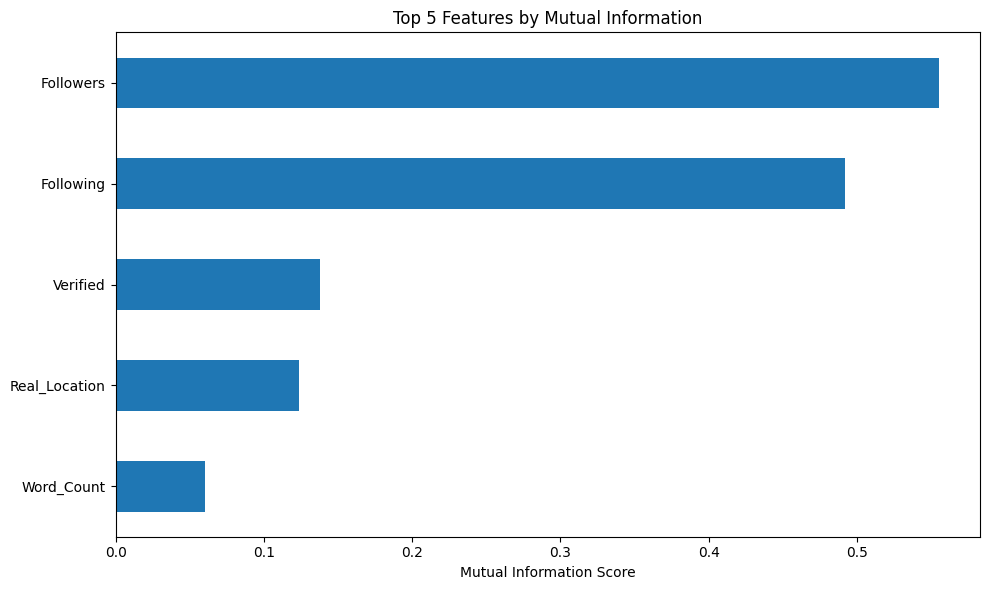

In [20]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
# Prepare the data (if not already done)
X = sml_data.drop(columns=['Label'])
y = sml_data['Label']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Select top 5 features
sel_five_cols = SelectKBest(mutual_info_classif, k=5)
sel_five_cols.fit(X_train, y_train)
# Get the names of the top 5 features
Top5Features = X_train.columns[sel_five_cols.get_support()]
# Print the top 5 features
print("Top 5 Features:")
print(Top5Features)
# Optional: Get the mutual information scores for these features
feature_scores = pd.Series(sel_five_cols.scores_, index=X_train.columns)
print("\nFeature Scores:")
print(feature_scores[Top5Features].sort_values(ascending=False))
# Visualization of top 5 feature scores
plt.figure(figsize=(10, 6))
feature_scores[Top5Features].sort_values().plot(kind='barh')
plt.title('Top 5 Features by Mutual Information')
plt.xlabel('Mutual Information Score')
plt.tight_layout()
plt.show()

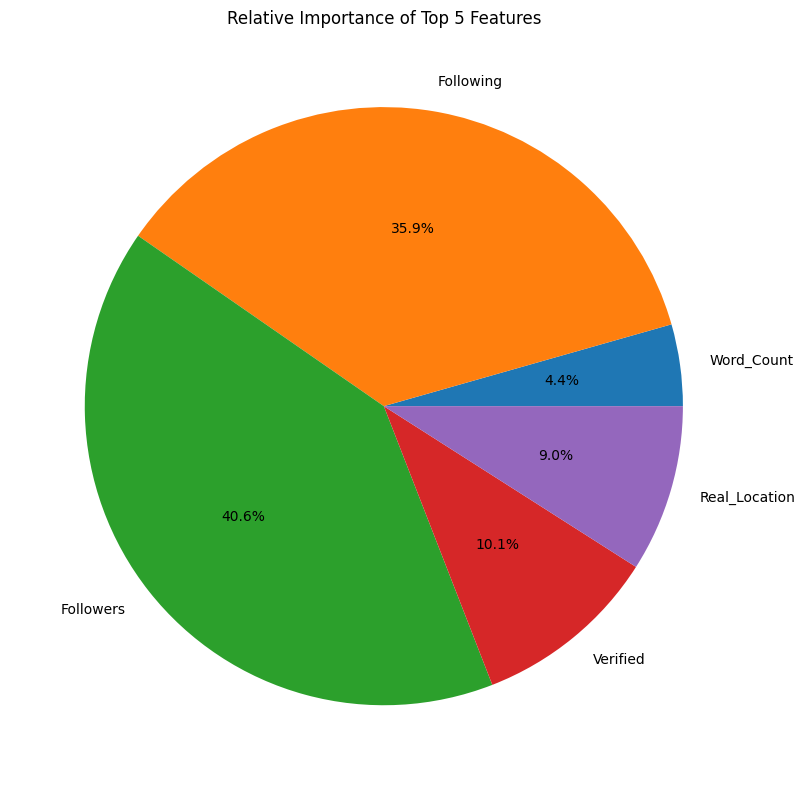


Detailed Feature Importance:
                     Feature  Mutual Information Score
Followers          Followers                  0.555161
Following          Following                  0.491968
Verified            Verified                  0.137680
Real_Location  Real_Location                  0.123655
Word_Count        Word_Count                  0.060377


In [23]:
# Pie chart of feature importance
plt.figure(figsize=(10, 8))
plt.pie(feature_scores[Top5Features], labels=Top5Features, autopct='%1.1f%%')
plt.title('Relative Importance of Top 5 Features')
plt.tight_layout()
plt.show()
# Detailed feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': Top5Features,
    'Mutual Information Score': feature_scores[Top5Features]
})
feature_importance = feature_importance.sort_values('Mutual Information Score', ascending=False)
print("\nDetailed Feature Importance:")
print(feature_importance)

In [25]:
data = pd.read_csv('TwitterData_Joined.csv')
data = data.sample(n=1000, random_state=42)

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (but keep the text)
    text = re.sub(r'#', '', text)
    # Remove emojis and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Data Cleaning
data['Tweet_text'] = data['Tweet_text'].apply(clean_text)  # Custom cleaning function
data.dropna(subset=['Tweet_text'], inplace=True)

In [26]:
# Funktion til at generere BERT-embeddings
def generate_bert_embeddings(texts, tokenizer, model, max_len=128):
    """Genererer BERT-embeddings for en liste af tekster."""
    tokens = tokenizer(
        texts, max_length=max_len, truncation=True, padding='max_length', return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**tokens)
    # CLS-tokenets embedding bruges som tekstrepræsentation
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    return cls_embeddings.numpy()

# Antager at 'data' allerede er indlæst
# Kolonner, der bruges til modeltræning
columns_to_keep = ['Label', 'Tweet_text', 'Followers', 'Following', 'Verified', 'Real_Location']
data = data[columns_to_keep]

# Splitting features og target
X = data.drop(columns=["Label"])  # Features
y = data["Label"]  # Target

# Initialiser tokenizer og DistilBERT-model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Generér BERT-embeddings for `Tweet_text`
tweet_texts = X['Tweet_text'].fillna("").tolist()
bert_embeddings = generate_bert_embeddings(tweet_texts, tokenizer, bert_model)

# Vægt embeddings
bert_weight = 10.0
weighted_bert_embeddings = bert_embeddings * bert_weight

# Tilføj embeddings til features og fjern `Tweet_text`
X_bert = pd.DataFrame(weighted_bert_embeddings, index=X.index)
X = pd.concat([X.drop(columns=['Tweet_text']), X_bert], axis=1)

# Konverter alle kolonnenavne til strings
X.columns = X.columns.astype(str)

# Identificer kategoriske og numeriske kolonner
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Inkluder numeriske BERT-kolonner
numerical_cols.extend([str(col) for col in range(weighted_bert_embeddings.shape[1])])

# Preprocessor til numeriske og kategoriske data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Split datasæt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest-model med hyperparameter-tuning
rf_model = RandomForestClassifier(class_weight='balanced')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')

# Transformer træningsdata
X_train_transformed = preprocessor.fit_transform(X_train)
grid_search.fit(X_train_transformed, y_train)

# Evaluér på test-sæt
X_test_transformed = preprocessor.transform(X_test)
y_test_pred = grid_search.best_estimator_.predict(X_test_transformed)
y_test_proba = grid_search.best_estimator_.predict_proba(X_test_transformed)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# Gem model og preprocessor
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(grid_search.best_estimator_, "best_model.pkl")
print("Model og preprocessor gemt!")

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       152
           1       0.83      0.91      0.87       148

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300

Test ROC AUC: 0.9476
Model og preprocessor gemt!


#### DistilBERT test

In [27]:
# Funktion til at generere BERT-embeddings
def generate_bert_embeddings(texts, tokenizer, model, max_len=128):
    """Genererer BERT-embeddings for en liste af tekster."""
    tokens = tokenizer(
        texts, max_length=max_len, truncation=True, padding='max_length', return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**tokens)
    # CLS-tokenets embedding bruges som tekstrepræsentation
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    return cls_embeddings.numpy()

# Antager at 'data' allerede er indlæst
# Kolonner, der bruges til modeltræning
columns_to_keep = ['Label', 'Tweet_text', 'Followers', 'Following', 'Verified', 'Real_Location']
data = data[columns_to_keep]

# Splitting features og target
X = data.drop(columns=["Label"])  # Features
y = data["Label"]  # Target

# Initialiser tokenizer og DistilBERT-model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Generér BERT-embeddings for `Tweet_text`
tweet_texts = X['Tweet_text'].fillna("").tolist()
bert_embeddings = generate_bert_embeddings(tweet_texts, tokenizer, bert_model)

# Vægt embeddings
bert_weight = 10.0
weighted_bert_embeddings = bert_embeddings * bert_weight

# Tilføj embeddings til features og fjern `Tweet_text`
X_bert = pd.DataFrame(weighted_bert_embeddings, index=X.index)
X = pd.concat([X.drop(columns=['Tweet_text']), X_bert], axis=1)

# Konverter alle kolonnenavne til strings
X.columns = X.columns.astype(str)

# Identificer kategoriske og numeriske kolonner
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Inkluder numeriske BERT-kolonner
numerical_cols.extend([str(col) for col in range(weighted_bert_embeddings.shape[1])])

# Preprocessor til numeriske og kategoriske data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Split datasæt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest-model med hyperparameter-tuning
rf_model = RandomForestClassifier(class_weight='balanced')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')

# Transformer træningsdata
X_train_transformed = preprocessor.fit_transform(X_train)
grid_search.fit(X_train_transformed, y_train)

# Evaluér på test-sæt
X_test_transformed = preprocessor.transform(X_test)
y_test_pred = grid_search.best_estimator_.predict(X_test_transformed)
y_test_proba = grid_search.best_estimator_.predict_proba(X_test_transformed)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# Gem model og preprocessor
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(grid_search.best_estimator_, "best_model.pkl")
print("Model og preprocessor gemt!")

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87       152
           1       0.83      0.95      0.89       148

    accuracy                           0.88       300
   macro avg       0.89      0.88      0.88       300
weighted avg       0.89      0.88      0.88       300

Test ROC AUC: 0.9444
Model og preprocessor gemt!


In [28]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
feature_names = preprocessor.get_feature_names_out()

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importance_df.sort_values(by="Importance", ascending=False))


                Feature  Importance
1        num__Following    0.064879
0        num__Followers    0.038909
3    num__Real_Location    0.037736
2         num__Verified    0.021091
755            num__751    0.005878
..                  ...         ...
562            num__558    0.000244
212            num__208    0.000242
499            num__495    0.000230
428            num__424    0.000187
586            num__582    0.000158

[772 rows x 2 columns]


In [29]:
# Efter generering af BERT embeddings
print("Eksempel på BERT embedding:", weighted_bert_embeddings[0][:10])  # Tjek værdier
print("Shape of BERT embeddings:", weighted_bert_embeddings.shape)

# Tjek sammenfletning af features
print("Shape før tilføjelse af BERT:", X.drop(columns=['Tweet_text']).shape)
print("Shape efter tilføjelse af BERT:", X.shape)  # Skal være flere kolonner end før


Eksempel på BERT embedding: [ 0.5156848  -2.789957    2.8028483  -0.22848235  2.5653543  -1.9684491
  3.7172241   2.9170551  -0.87884045 -2.3663986 ]
Shape of BERT embeddings: (1000, 768)


KeyError: "['Tweet_text'] not found in axis"

In [30]:
def predict_tweet(tweet_text, followers, following, verified, location, bert_model, tokenizer, preprocessor, model):
    """Genererer en prediction for et enkelt tweet."""
    # Generér BERT-embedding for tweet_text
    tweet_embedding = generate_bert_embeddings([tweet_text], tokenizer, bert_model)
    tweet_embedding = tweet_embedding * 2.0

    # Saml input som en DataFrame
    input_data = pd.DataFrame({
        "Followers": [followers],
        "Following": [following],
        "Verified": [1 if verified.lower() == "yes" else 0],
        "Real_Location": [location]
    })
    
    # Tilføj BERT-embedding
    bert_embedding_df = pd.DataFrame(tweet_embedding, index=input_data.index)
    full_input = pd.concat([input_data, bert_embedding_df], axis=1)

    # Konverter kolonnenavne til strings
    full_input.columns = full_input.columns.astype(str)

    # Transformér data
    transformed_input = preprocessor.transform(full_input)

    # Lav prediction
    prediction = model.predict(transformed_input)
    probability = model.predict_proba(transformed_input)[:, 1]
    return prediction[0], probability[0]


In [31]:
# Indlæs preprocessor og model
preprocessor = joblib.load("preprocessor.pkl")
best_model = joblib.load("best_model.pkl")

# Test med et nyt tweet
tweet_text = "I'm a robot"
followers = 1000
following = 540
verified = "Yes"
location = "1"

prediction, probability = predict_tweet(
    tweet_text=tweet_text,
    followers=followers,
    following=following,
    verified=verified,
    location=location,
    bert_model=bert_model,
    tokenizer=tokenizer,
    preprocessor=preprocessor,
    model=best_model
)

print(f"Prediction: {prediction}, Probability: {probability:.4f}")


Prediction: 1, Probability: 0.6525


In [33]:
import gradio as gr
import joblib
import pandas as pd
import torch

# Indlæs preprocessor og model
preprocessor = joblib.load("preprocessor.pkl")
best_model = joblib.load("best_model.pkl")

# Initialiser tokenizer og BERT-model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Funktion til at generere BERT-embeddings
def generate_bert_embeddings(texts, tokenizer, model, max_len=128):
    """Genererer BERT-embeddings for en liste af tekster."""
    tokens = tokenizer(
        texts, max_length=max_len, truncation=True, padding='max_length', return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**tokens)
    # CLS-tokenets embedding bruges som tekstrepræsentation
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    return cls_embeddings.numpy()

# Predict-funktion
def predict_tweet(tweet_text, followers, following, verified, location):
    """Genererer en prediction for et enkelt tweet."""
    # Generér BERT-embedding for tweet_text
    tweet_embedding = generate_bert_embeddings([tweet_text], tokenizer, bert_model)
    tweet_embedding = tweet_embedding * 2.0

    # Saml input som en DataFrame
    input_data = pd.DataFrame({
        "Followers": [followers],
        "Following": [following],
        "Verified": [1 if verified.lower() == "yes" else 0],
        "Real_Location": [location]
    })
    
    # Tilføj BERT-embedding
    bert_embedding_df = pd.DataFrame(tweet_embedding, index=input_data.index)
    full_input = pd.concat([input_data, bert_embedding_df], axis=1)

    # Konverter kolonnenavne til strings
    full_input.columns = full_input.columns.astype(str)

    # Transformér data
    transformed_input = preprocessor.transform(full_input)

    # Lav prediction
    prediction = best_model.predict(transformed_input)
    probability = best_model.predict_proba(transformed_input)[:, 1]
    return prediction[0], probability[0]

# Gradio UI
interface = gr.Interface(
    fn=predict_tweet,
    inputs=[
        gr.Textbox(label="Tweet Text", placeholder="Enter the tweet text"),
        gr.Number(label="Followers", value=0),
        gr.Number(label="Following", value=0),
        gr.Radio(label="Verified", choices=["Yes", "No"], value="No"),
        gr.Number(label="Real Location (1 for True, 0 for False)", value=1)
    ],
    outputs=[
        gr.Textbox(label="Prediction Result"),
        gr.Textbox(label="Prediction Probability")
    ],
    title="Tweet Sentiment Prediction",
    description="Predict the sentiment or classification of a tweet based on its text and metadata.",
)

# Launch Gradio interface
if __name__ == "__main__":
    interface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://36a761f0675237e3a9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
